In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
import scipy.sparse.linalg as spLA
import networkx as nx

import sys
sys.path.insert(1, "../")

import SpringRank_tools as sr
import tools as tl

from time import time
from copy import deepcopy as copy

%load_ext autoreload
%aimport SpringRank_tools
%aimport tools
%autoreload 1

%matplotlib inline

## Update Process

In [30]:
def Laplacian(G):
    k_in = np.sum(G, 0)
    k_out = np.sum(G, 1)
    return np.diag(k_in + k_out) - (A + A.T)

def operator_P(x, P):
    if len(x.shape) == 2:
        x_P = x[P][:, P]
    elif len(x.shape) == 1:
        x_P = x[P]
    else:
        raise ValueError("Invalid shape")
    return x_P

def get_neighbors(G, P):
    idx_0 = set(np.nonzero(G[P])[1])
    idx_1 = set(np.nonzero(G[:,P])[0])
    N = idx_0.union(idx_1) - set(P)
    return list(N)

def collect_neighborhood(G, P, order):
    N = set(P)
    for k in range(order):
        N = N.union(get_neighbors(G, list(N)))
    return list(N)

In [79]:
def update_ranks(A, s_0, P):
    L = Laplacian(A)
    s_est = copy(s_0)
    d_hat = np.sum(A, 1) - np.sum(A, 0)
    RHS = d_hat - np.matmul(L, s_0)
    
    L_p = operator_P(L, P)    
    RHS_p = operator_P(RHS, P)
    
    result = spLA.spsolve(L_p, RHS_p)
    delta_p = result
    
    delta_p = delta_p - np.mean(delta_p)
    
    s_est[P] = s_est[P] + delta_p
    
    return s_est, delta_p

def lagrange_multipliers(A, s_0, neighbors):
    L = Laplacian(A)
    K = np.copy(L)
    
    ctr = 0
    N = A.shape[0]
    M = N - len(neighbors)
    fixed_nodes_matrix = np.zeros((N, M))
    for idx in range(N):
        if idx not in neighbors:
            fixed_nodes_matrix[idx, ctr] = 1
            ctr += 1
    K = np.append(K, fixed_nodes_matrix, axis=1)
    K = np.append(K, np.append(fixed_nodes_matrix.T, np.zeros((M, M)), axis=1), axis=0)
    
    fixed_nodes = list(set(range(N)) - set(neighbors))
    RHS = np.sum(A, axis=1) - np.sum(A, axis=0)
    RHS = np.append(RHS, s_0[fixed_nodes], axis=0)

    result = spLA.lsqr(K, RHS)
    x = result[0]
    s_est = x[:N]
    lamb = x[N:]
    
    return s_est, lamb 

def kth_order_update(A, s_0, N0, order, option="reduced", return_compute_times=False):
    
    start_time = time()
    N = collect_neighborhood(A, N0, order)
    end_time = time()
    neighbor_time = end_time - start_time
    
    start_time = time()
    
    if option == "reduced":
        print("Computing updates via solving the new Hamiltonian")
        s_est, delta_p = update_ranks(A, s_0, N)
    elif option == "lagrange":
        print("Computing ranks via Lagrange multipliers")
        s_est, lamb = lagrange_multipliers(A, s_0, N)
    
    end_time = time()
    solve_time = end_time - start_time
    
    if return_compute_times:
        return s_est, N, (neighbor_time, solve_time)
    else:
        return s_est, N

## Simple Test Case #1
The original system is essentially a directed link list. The final system closes the linked list creating a cycle. We expect all the nodes in the final system to have the same rank.

In [15]:
N = 10
A0 = np.zeros((N, N))
for i in range(N-1):
    A0[i, i+1] = 1
s0 = sr.SpringRank(A0)
s0 = tl.adjust_ranks(s0, A0, p_ij=0.999)

print(s0)

[52.12183977 46.33061583 40.53937633 34.74812459 28.95684705 23.16553783
 17.37419254 11.58281466  5.7914168   0.        ]


In [16]:
A = np.copy(A0)
A[N-1, 0] = 1

s = sr.SpringRank(A)
s = tl.adjust_ranks(s, A, p_ij=0.999)

print(s)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [23]:
k = 4
sk, neighbors_k = kth_order_update(A, s0, N0=[N-1, 0], order=k)

sk = tl.shift_ranks(sk)

print(sk)

9 10
[1.38555833e-13 2.13162821e-14 7.46069873e-14 5.68434189e-14
 7.81597009e-14 7.10542736e-15 9.94759830e-14 3.90798505e-14
 9.59232693e-14 0.00000000e+00]


Okay, works!

## Simple Test Case #2
Here, the final system is a directed linked list. The original system misses an edge that makes it a linked list.

In [24]:
N = 10
missing_node = np.random.randint(0, N-1)
A0 = np.zeros((N, N))
for i in range(N-1):
    if i == missing_node:
        continue
    A0[i, i+1] = 1
# if i != (N-1):
#     A0[N-1, 0] = 1
s0 = sr.SpringRank(A0)
s0 = tl.adjust_ranks(s0, A0, p_ij=0.999)

print(missing_node)
print(s0)

7
[40.54002038 34.74858916 28.95715788 23.16572653 17.37429507 11.58286352
  5.79143181  0.         43.43573637 37.64430445]


In [23]:
A = np.copy(A0)
A[missing_node, missing_node+1] = 1

s = sr.SpringRank(A)
s = tl.adjust_ranks(s, A, p_ij=0.999)

print(s)

[52.12183977 46.33061583 40.53937633 34.74812459 28.95684705 23.16553783
 17.37419254 11.58281466  5.7914168   0.        ]


In [27]:
k = 5
sk, neighbors_k = kth_order_update(A, s0, N0=[missing_node, missing_node+1], order=k)

# sk = tl.adjust_ranks(sk, A, p_ij=0.999, interval=(-1000, 100))

print(neighbors_k)
print(sk)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[18.39943658 17.39943658 16.39943658 15.39943658 14.39943658 13.39943658
 12.39943658 11.39943658 10.39943658  9.39943658]


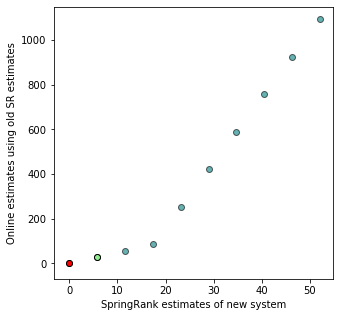

In [126]:
plt.figure(figsize=(5,5))

plt.scatter(s, sk, color="teal", edgecolor="black", alpha=0.6)

plt.scatter(s[missing_node], sk[missing_node], color="lightgreen", edgecolor="black")
plt.scatter(s[missing_node+1], sk[missing_node+1], color="red", edgecolor="black")

plt.xlabel("SpringRank estimates of new system")
plt.ylabel("Online estimates using old SR estimates")

plt.show()

Okay, works!

## Test on large network

In [89]:
beta = 0.5
p_ij = 1 / (1 + np.exp(-2*beta))
alpha = 1
N = 500
K = 10

A_0 = sr.SpringRank_planted_network(N, beta, alpha, K)
s_0 = sr.SpringRank(A_0)
s_0 = tl.adjust_ranks(s_0, A_0, p_ij=p_ij)

In [90]:
node_x = 35
node_y = 70
A_xy = 1
A_yx = 0

A = copy(A_0)
A[node_x, node_y] += A_xy
A[node_y, node_x] += A_yx
P = [node_x, node_y]

In [95]:
s = sr.SpringRank(A)
s = tl.adjust_ranks(s, A, p_ij=p_ij)

print("Difference:")
print(LA.norm(s - s_0, ord=1))
print(LA.norm(s - s_0, ord=1) / LA.norm(s_0, ord=1))

Difference:
0.7685962301201346
0.0003057187019441996


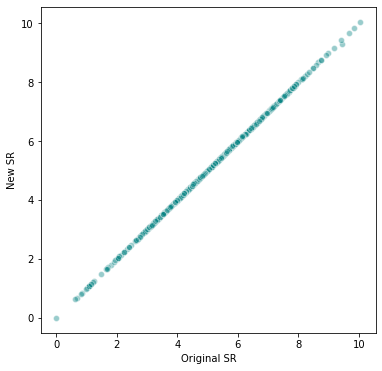

In [94]:
plt.figure(figsize=(6, 6))

plt.scatter(s_0, s, color='teal', edgecolor='white', alpha=0.4)

plt.xlabel("Original SR")
plt.ylabel("New SR")

plt.show()

### kth order update

In [86]:
s_all = []
fraction_nodes = []
neighbors = []
errors = []
elapsed_times = []
neighbor_times = []
solve_times = []

max_order = 5
orders = list(range(max_order+1))

num_reps = 1

baseline_time = 0
for i in range(num_reps):
    start_time = time()
    _ = sr.SpringRank(A)
    end_time = time()
    baseline_time += end_time - start_time
baseline_time /= num_reps

for k in orders:
    
    elapsed_time_k = 0
    neighbor_time_k = 0
    solve_time_k = 0
    for i in range(num_reps):
        start_time = time()
        s_k, N_k, times = kth_order_update(A, s_0, P, order=k, option="lagrange", return_compute_times=True)
        end_time = time()
        elapsed_time_k += end_time - start_time
        neighbor_time_k += times[0]
        solve_time_k += times[1]
    elapsed_times.append(elapsed_time_k / num_reps)
    neighbor_times.append(neighbor_time_k / num_reps)
    solve_times.append(solve_time_k / num_reps)
    
    fraction_k = len(N_k) / N
    fraction_nodes.append(fraction_k)
    
    s_k = tl.shift_ranks(s_k)
#     s_k = tl.adjust_ranks(s_k, A, p_ij=p_ij)
    s_all.append(s_k)
    neighbors.append(N_k)
    
    error_k = LA.norm(s_k - s, ord=2)
    errors.append(error_k)

Computing ranks via Lagrange multipliers
Computing ranks via Lagrange multipliers
Computing ranks via Lagrange multipliers
Computing ranks via Lagrange multipliers
Computing ranks via Lagrange multipliers
Computing ranks via Lagrange multipliers


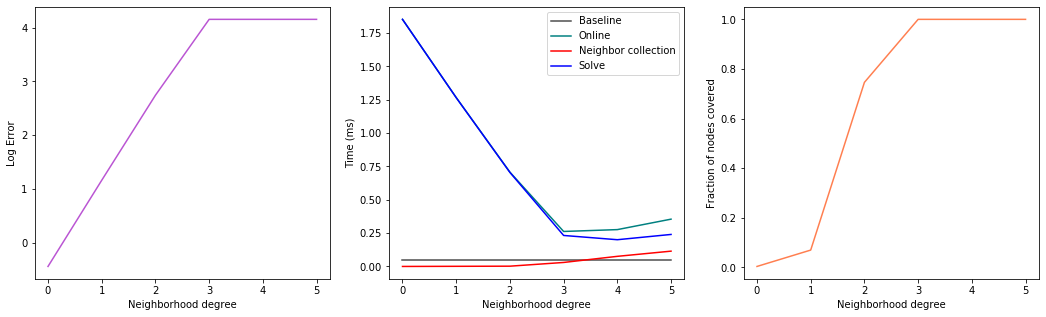

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for i in range(3):
    ax[i].set_xlabel("Neighborhood degree")
    ax[i].set_xticks(orders)

ax[0].plot(orders, np.log(errors), color="mediumorchid")
ax[0].set_ylabel("Log Error")


ax[1].plot(orders, [baseline_time]*len(orders), color='black', alpha=0.7, label="Baseline")
ax[1].plot(orders, elapsed_times, color="teal", label="Online")
ax[1].plot(orders, neighbor_times, color="red", label="Neighbor collection")
ax[1].plot(orders, solve_times, color="blue", label="Solve")
ax[1].set_ylabel("Time (ms)")
ax[1].legend()


ax[2].plot(orders, fraction_nodes, color="coral")
ax[2].set_ylabel("Fraction of nodes covered")

plt.show()

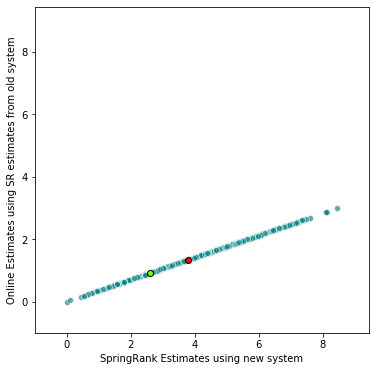

In [88]:
plt.figure(figsize=(6, 6))

k = 5

plt.scatter(s, s_all[k], color="grey", edgecolor="white", alpha=0.4)

plt.scatter(s[neighbors[k]], s_all[k][neighbors[k]], color="teal", edgecolor="white", alpha=0.5)

plt.scatter(s[node_x], s_all[k][node_x], color="red", edgecolor="black")
plt.scatter(s[node_y], s_all[k][node_y], color="lawngreen", edgecolor="black")

plt.xlim(min(np.min(s), np.min(s_all))-1, max(np.max(s), np.max(s_all))+1)
plt.ylim(min(np.min(s), np.min(s_all))-1, max(np.max(s), np.max(s_all))+1)

plt.xlabel("SpringRank Estimates using new system")
plt.ylabel("Online Estimates using SR estimates from old system")


plt.show()

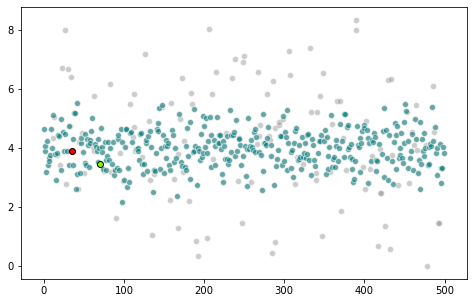

In [56]:
plt.figure(figsize=(8, 5))

plt.scatter(range(len(s)), s_all[k], color="grey", edgecolor="white", alpha=0.4)

plt.scatter(neighbors[k], s_all[k][neighbors[k]], color="teal", edgecolor="white", alpha=0.5)

plt.scatter(node_x, s_all[k][node_x], color="red", edgecolor="black")
plt.scatter(node_y, s_all[k][node_y], color="lawngreen", edgecolor="black")

plt.show()